In [243]:
#STEP one fit good model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ordinal_xai.utils import load_data
from sklearn.model_selection import train_test_split

X,y = load_data("ordinal_xai/data/winequality-red.csv")#,sep=",")#,label_map={"unacc":0,"acc":1,"good":2,"vgood":3})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from ordinal_xai.models import CLM,ONN,OBD
from ordinal_xai.utils import evaluate_ordinal_model


model = OBD(base_classifier="xgb",decomposition_type="one-vs-following")

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
y_pred_train = model.predict(X_train)
y_pred_proba_train = model.predict_proba(X_train)
print(evaluate_ordinal_model(y_train,y_pred_train,y_pred_proba_train))
print(evaluate_ordinal_model(y_test,y_pred,y_pred_proba))
#refit model on full data
model.fit(X,y)
y_pred=model.predict(X)
y_pred_proba=model.predict_proba(X)



{'accuracy': 0.800625488663018, 'adjacent_accuracy': 0.9843627834245504, 'mze': 0.19937451133698203, 'mae': 0.21579358874120408, 'mse': 0.2501954652071931, 'weighted_kappa_quadratic': 0.7844599227535709, 'weighted_kappa_linear': 0.7261909009535895, 'cem': 0.8342706258436001, 'spearman_correlation': 0.7712083357544592, 'kendall_tau': 0.7455880703163329, 'ranked_probability_score': 0.1766763479920882, 'ordinal_weighted_ce_linear': 0.549229864221745, 'ordinal_weighted_ce_quadratic': 0.7140017688787844}
{'accuracy': 0.63125, 'adjacent_accuracy': 0.9875, 'mze': 0.36875, 'mae': 0.38125, 'mse': 0.40625, 'weighted_kappa_quadratic': 0.6287239169626759, 'weighted_kappa_linear': 0.5042791477258297, 'cem': 0.7180186382218141, 'spearman_correlation': 0.6450715185465562, 'kendall_tau': 0.6010054406985176, 'ranked_probability_score': 0.2745957430777267, 'ordinal_weighted_ce_linear': 0.7472586697604687, 'ordinal_weighted_ce_quadratic': 0.9211852209318444}


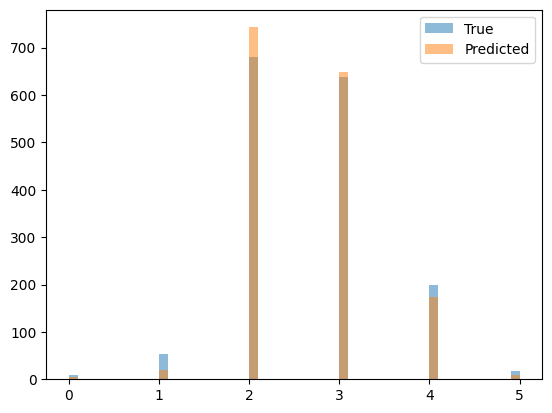

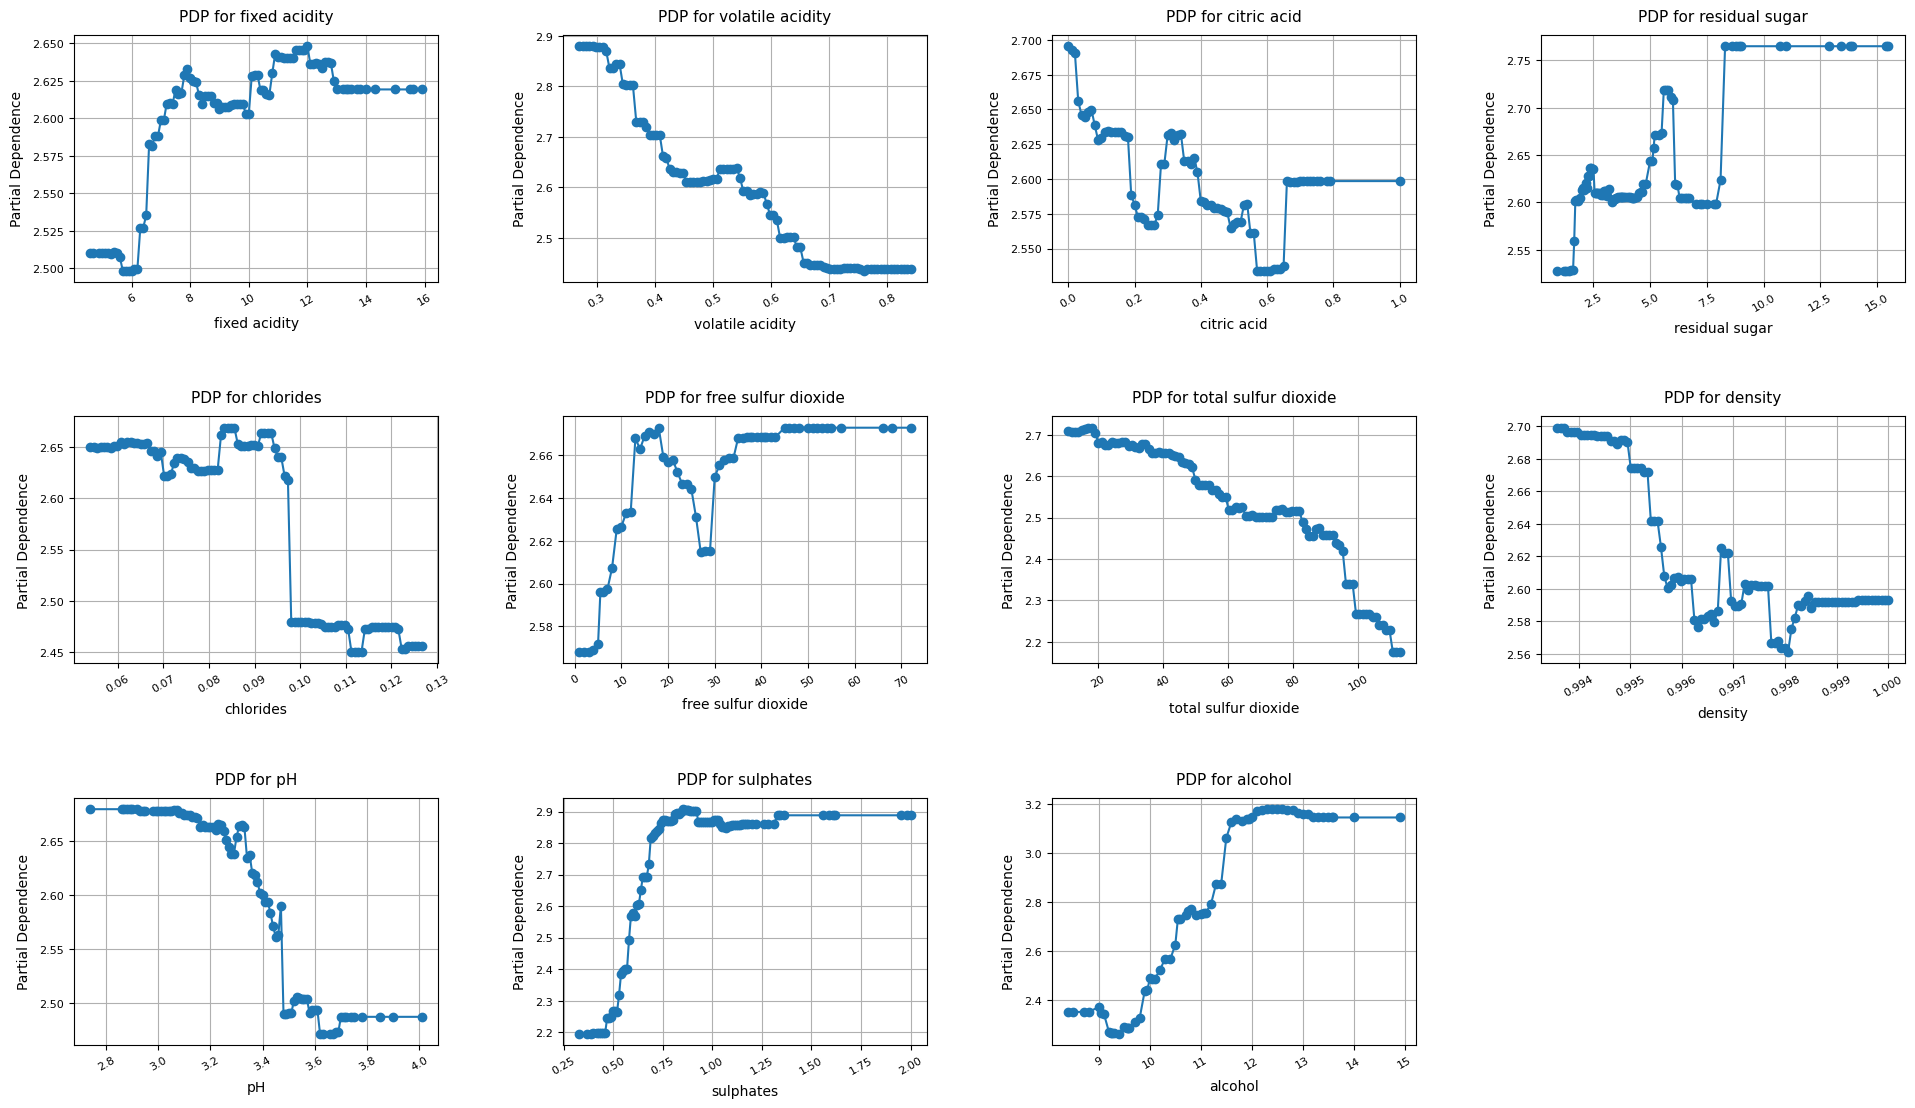

Generated PDPs for features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


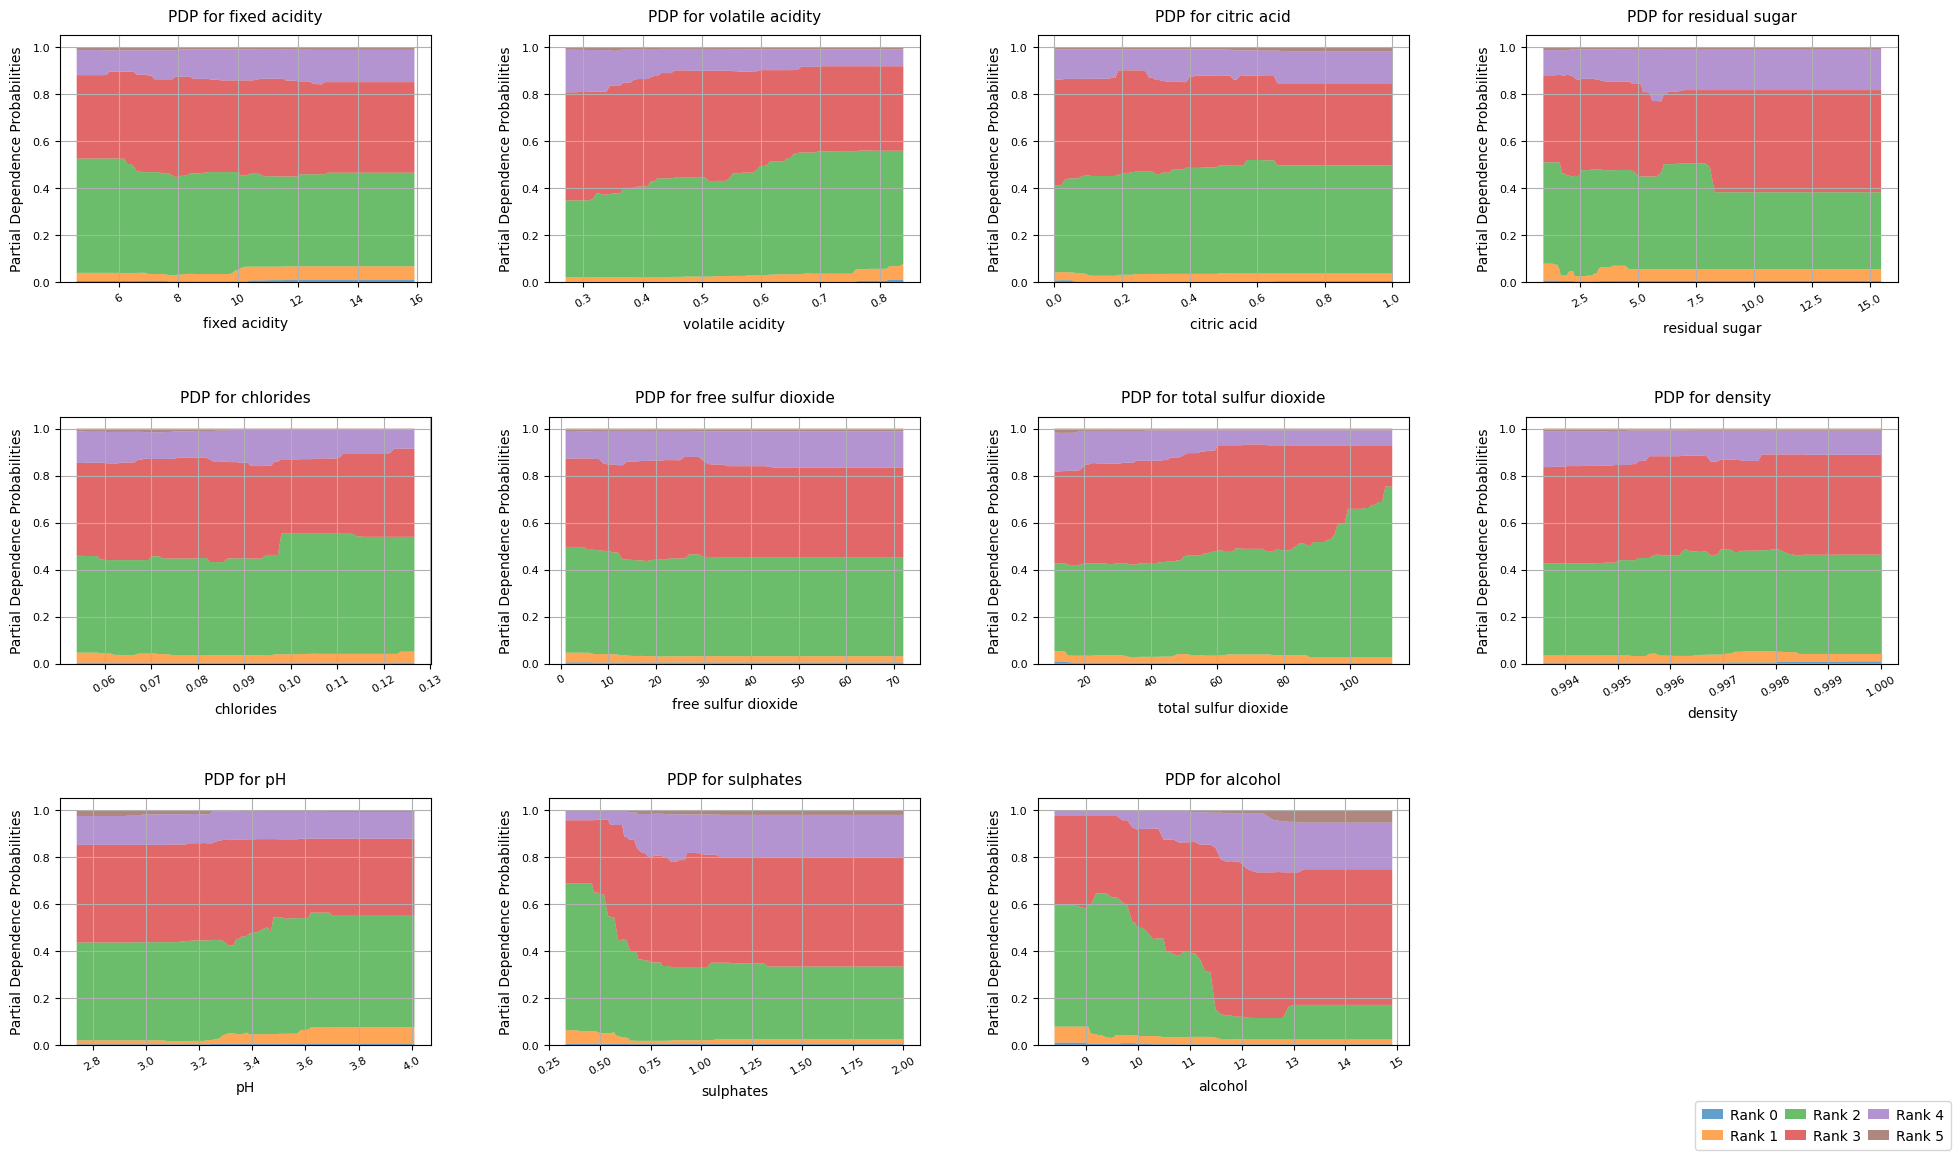

Generated PDPs for features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


{'fixed acidity': {'grid_values': [array([ 4.6,  4.7,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,  5.6,  5.7,
           5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,  6.7,  6.8,
           6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,  7.8,  7.9,
           8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,  8.9,  9. ,
           9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9, 10. , 10.1,
          10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11. , 11.1, 11.2,
          11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. , 12.1, 12.2, 12.3,
          12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.2, 13.3, 13.4, 13.5,
          13.7, 13.8, 14. , 14.3, 15. , 15.5, 15.6, 15.9])],
  'average': array([[0.00561475, 0.00561475, 0.00561475, 0.00561475, 0.00561475,
          0.00561475, 0.00561475, 0.00561475, 0.00561475, 0.00561475,
          0.00561475, 0.00561475, 0.00561475, 0.00561475, 0.00561475,
          0.00561475, 0.00561475, 0.00561475, 0.00561475, 0.00561475,
        

In [206]:
#use pdps and ices to understand model and predictions

#plot histogram of true vs predicted distribution
plt.hist(y, bins=50, alpha=0.5, label='True',log=False)
plt.hist(y_pred, bins=50, alpha=0.5, label='Predicted',log=False)
plt.legend()
plt.show()

from ordinal_xai.interpretation.pdp import PDP
from ordinal_xai.interpretation.pdp_prob import PDPProb


pdp = PDP(model, X, y)
pdp.explain(plot=True)

pdp_prob = PDPProb(model, X, y)
pdp_prob.explain(plot=True)



In [238]:
#generate set of observations that is uniform distributed across ranks, generator yield
import math
def generate_observations(y,n=100,balance_classes=True):
    #set random seed
    np.random.seed(42)
    if balance_classes == False:
        for i in range(n):
            yield np.random.randint(0,len(y))
        return
    yc = y.copy()
    classes = np.unique(yc)
    for i in range(n):
        random_class = np.random.choice(classes)
        try:
            obs = np.random.choice(np.where(yc==random_class)[0])
        except:
            "not enough samples for class",random_class
            return
        #yc[obs] = -1
        yield obs



In [245]:
#Perform lime repeatedly and save fidelity values
from ordinal_xai.interpretation import LIME

following_df = pd.DataFrame(columns=["idx","true_rank","predicted_rank","higher_fidelity_in_bce","higher_fidelity_in_01","higher_fidelity_out_bce","higher_fidelity_out_01","lower_fidelity_in_bce","lower_fidelity_in_01","lower_fidelity_out_bce","lower_fidelity_out_01"])
next_df =pd.DataFrame(columns=["idx","true_rank","predicted_rank","higher_fidelity_in_bce","higher_fidelity_in_01","higher_fidelity_out_bce","higher_fidelity_out_01","lower_fidelity_in_bce","lower_fidelity_in_01","lower_fidelity_out_bce","lower_fidelity_out_01"])
count = 0
lime_following = LIME(model=model,X=X,y=y,comparison_method="one_vs_following",model_type="decision_tree",kernel_width=0.75,sampling="uniform",max_samples=5000)
lime_next = LIME(model=model,X=X,y=y,comparison_method="one_vs_next",model_type="decision_tree",kernel_width=0.75,sampling="uniform",max_samples=5000)

for idx in generate_observations(y_pred,2000):
    count += 1
    if count % 100 == 0:
        print(count)
    results_following = lime_following.explain(idx)
    results_next = lime_next.explain(idx)
    if "higher_fidelity_in" not in results_next:
        results_next["higher_fidelity_in"],results_next["higher_fidelity_out"] = (None,None), (None,None) 
    if "lower_fidelity_in" not in results_next:
        results_next["lower_fidelity_in"],results_next["lower_fidelity_out"] = (None,None), (None,None)
    if "higher_fidelity_in" not in results_following:
        results_following["higher_fidelity_in"],results_following["higher_fidelity_out"] = (None,None), (None,None) 
    if "lower_fidelity_in" not in results_following:
        results_following["lower_fidelity_in"],results_following["lower_fidelity_out"] = (None,None), (None,None)
    following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results_following["lower_fidelity_out"][1]]})],ignore_index=True)
    next_df = pd.concat([next_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_next["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_next["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_next["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_next["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_next["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_next["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_next["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results_next["lower_fidelity_out"][1]]})],ignore_index=True)

print(count)

C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2557348961.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

100


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2557348961.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

200


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2557348961.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

300


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2557348961.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

400


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2557348961.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

KeyboardInterrupt: 

following_fidelities                 higher_fidelity_out_bce  lower_fidelity_out_bce  \
predicted_rank                                                    
0                              0.123267                     NaN   
1                              0.433324                0.119312   
2                              0.400637                0.424178   
3                              0.459804                0.399785   
4                              0.129350                0.476735   
5                                   NaN                0.132365   

                higher_fidelity_out_01  lower_fidelity_out_01  
predicted_rank                                                 
0                             0.025420                    NaN  
1                             0.241069               0.025233  
2                             0.190175               0.240921  
3                             0.143072               0.190247  
4                             0.028846               0.147

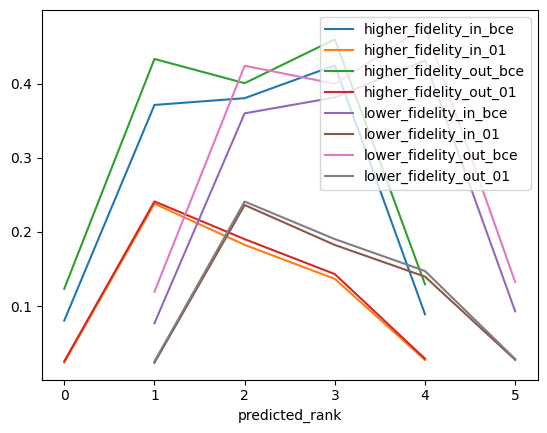

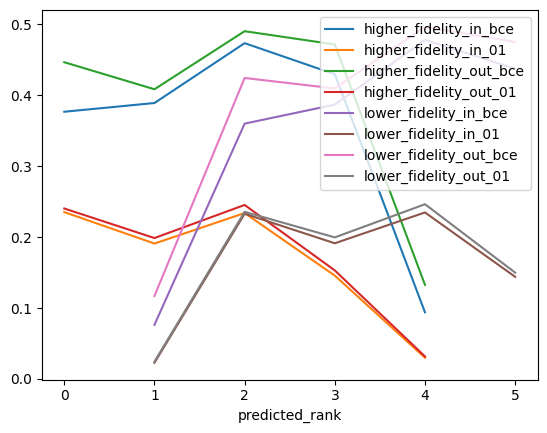

In [231]:
following_df.groupby("predicted_rank")[["higher_fidelity_in_bce","higher_fidelity_in_01","higher_fidelity_out_bce","higher_fidelity_out_01","lower_fidelity_in_bce","lower_fidelity_in_01","lower_fidelity_out_bce","lower_fidelity_out_01"]].mean().plot()
next_df.groupby("predicted_rank")[["higher_fidelity_in_bce","higher_fidelity_in_01","higher_fidelity_out_bce","higher_fidelity_out_01","lower_fidelity_in_bce","lower_fidelity_in_01","lower_fidelity_out_bce","lower_fidelity_out_01"]].mean().plot()

print("following_fidelities", following_df.groupby("predicted_rank")[["higher_fidelity_out_bce","lower_fidelity_out_bce","higher_fidelity_out_01","lower_fidelity_out_01"]].mean())
print("next_fidelities", next_df.groupby("predicted_rank")[["higher_fidelity_out_bce","lower_fidelity_out_bce","higher_fidelity_out_01","lower_fidelity_out_01"]].mean())

In [227]:
in_sample_bce_following = np.mean([following_df['higher_fidelity_in_bce'].mean(), following_df['lower_fidelity_in_bce'].mean()])
print("in_sample_bce_following", in_sample_bce_following)

out_sample_bce_following = np.mean([following_df['higher_fidelity_out_bce'].mean(), following_df['lower_fidelity_out_bce'].mean()])
print("out_sample_bce_following", out_sample_bce_following)

in_sample_01_following = np.mean([following_df['higher_fidelity_in_01'].mean(), following_df['lower_fidelity_in_01'].mean()])
print("in_sample_01_following", in_sample_01_following)

out_sample_01_following = np.mean([following_df['higher_fidelity_out_01'].mean(), following_df['lower_fidelity_out_01'].mean()])
print("out_sample_01_following", out_sample_01_following)

in_sample_bce_next = np.mean([next_df['higher_fidelity_in_bce'].mean(), next_df['lower_fidelity_in_bce'].mean()])
print("in_sample_bce_next", in_sample_bce_next)

out_sample_bce_next = np.mean([next_df['higher_fidelity_out_bce'].mean(), next_df['lower_fidelity_out_bce'].mean()])
print("out_sample_bce_next", out_sample_bce_next)

in_sample_01_next = np.mean([next_df['higher_fidelity_in_01'].mean(), next_df['lower_fidelity_in_01'].mean()])
print("in_sample_01_next", in_sample_01_next)

out_sample_01_next = np.mean([next_df['higher_fidelity_out_01'].mean(), next_df['lower_fidelity_out_01'].mean()])
print("out_sample_01_next", out_sample_01_next)


in_sample_bce_following 0.2672129028433129
out_sample_bce_following 0.3085472188864928
in_sample_01_following 0.12146175319871841
out_sample_01_following 0.1257799519153282
in_sample_bce_next 0.34860850424952944
out_sample_bce_next 0.3857195790644105
in_sample_01_next 0.16568558485309007
out_sample_01_next 0.17200754308206923


In [247]:
#Perform lime repeatedly and save fidelity values
from ordinal_xai.interpretation import LIME

following_df = pd.DataFrame(columns=["idx","true_rank","predicted_rank","higher_fidelity_in_bce","higher_fidelity_in_01","higher_fidelity_out_bce","higher_fidelity_out_01","lower_fidelity_in_bce","lower_fidelity_in_01","lower_fidelity_out_bce","lower_fidelity_out_01"])
next_df =pd.DataFrame(columns=["idx","true_rank","predicted_rank","higher_fidelity_in_bce","higher_fidelity_in_01","higher_fidelity_out_bce","higher_fidelity_out_01","lower_fidelity_in_bce","lower_fidelity_in_01","lower_fidelity_out_bce","lower_fidelity_out_01"])
count = 0
lime_following = LIME(model=model,X=X,y=y,comparison_method="one_vs_following",model_type="decision_tree",kernel_width=0.75,sampling="uniform",max_samples=5000)
lime_next = LIME(model=model,X=X,y=y,comparison_method="one_vs_next",model_type="decision_tree",kernel_width=0.75,sampling="uniform",max_samples=5000)

for idx in generate_observations(y_pred,2000,balance_classes=False):
    count += 1
    if count % 100 == 0:
        print(count)
    results_following = lime_following.explain(idx)
    results_next = lime_next.explain(idx)
    if "higher_fidelity_in" not in results_next:
        results_next["higher_fidelity_in"],results_next["higher_fidelity_out"] = (None,None), (None,None) 
    if "lower_fidelity_in" not in results_next:
        results_next["lower_fidelity_in"],results_next["lower_fidelity_out"] = (None,None), (None,None)
    if "higher_fidelity_in" not in results_following:
        results_following["higher_fidelity_in"],results_following["higher_fidelity_out"] = (None,None), (None,None) 
    if "lower_fidelity_in" not in results_following:
        results_following["lower_fidelity_in"],results_following["lower_fidelity_out"] = (None,None), (None,None)
    following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results_following["lower_fidelity_out"][1]]})],ignore_index=True)
    next_df = pd.concat([next_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_next["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_next["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_next["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_next["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_next["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_next["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_next["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results_next["lower_fidelity_out"][1]]})],ignore_index=True)

print(count)

C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2590941331.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

100


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2590941331.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

200


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2590941331.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

300


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2590941331.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

400
500


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2590941331.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

600
700


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2590941331.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

800


Failed to fit higher class model: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2590941331.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  next_df = pd.concat([next_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_next["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_next["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_next["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_next["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_next["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_next

900
1000


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2590941331.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

1100


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2590941331.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

1200


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2590941331.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

1300


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2590941331.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

1400


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2590941331.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

1500


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2590941331.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

1600


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2590941331.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

1700
1800


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2590941331.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

1900


C:\Users\wankm\AppData\Local\Temp\ipykernel_33076\2590941331.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  following_df = pd.concat([following_df,pd.DataFrame({"idx":[idx],"true_rank":[y[idx]],"predicted_rank":[y_pred[idx]],"higher_fidelity_in_bce":[results_following["higher_fidelity_in"][0]],"higher_fidelity_in_01":[results_following["higher_fidelity_in"][1]],"higher_fidelity_out_bce":[results_following["higher_fidelity_out"][0]],"higher_fidelity_out_01":[results_following["higher_fidelity_out"][1]],"lower_fidelity_in_bce":[results_following["lower_fidelity_in"][0]],"lower_fidelity_in_01":[results_following["lower_fidelity_in"][1]],"lower_fidelity_out_bce":[results_following["lower_fidelity_out"][0]],"lower_fidelity_out_01":[results

2000
2000


In [1]:
in_sample_bce_following = np.mean([following_df['higher_fidelity_in_bce'].mean(), following_df['lower_fidelity_in_bce'].mean()])
print("in_sample_bce_following", in_sample_bce_following)

out_sample_bce_following = np.mean([following_df['higher_fidelity_out_bce'].mean(), following_df['lower_fidelity_out_bce'].mean()])
print("out_sample_bce_following", out_sample_bce_following)

in_sample_01_following = np.mean([following_df['higher_fidelity_in_01'].mean(), following_df['lower_fidelity_in_01'].mean()])
print("in_sample_01_following", in_sample_01_following)

out_sample_01_following = np.mean([following_df['higher_fidelity_out_01'].mean(), following_df['lower_fidelity_out_01'].mean()])
print("out_sample_01_following", out_sample_01_following)

in_sample_bce_next = np.mean([next_df['higher_fidelity_in_bce'].mean(), next_df['lower_fidelity_in_bce'].mean()])
print("in_sample_bce_next", in_sample_bce_next)

out_sample_bce_next = np.mean([next_df['higher_fidelity_out_bce'].mean(), next_df['lower_fidelity_out_bce'].mean()])
print("out_sample_bce_next", out_sample_bce_next)

in_sample_01_next = np.mean([next_df['higher_fidelity_in_01'].mean(), next_df['lower_fidelity_in_01'].mean()])
print("in_sample_01_next", in_sample_01_next)

out_sample_01_next = np.mean([next_df['higher_fidelity_out_01'].mean(), next_df['lower_fidelity_out_01'].mean()])
print("out_sample_01_next", out_sample_01_next)

NameError: name 'np' is not defined

TypeError: __init__() got an unexpected keyword argument 'max_depth'